In [2]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import PercentFormatter
from scipy import stats


In [3]:
%matplotlib inline
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 7.5)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22


 # Computational Statistics Homework 07
 
 Kalin Gibbons  
 2020-03-19


 ## Problem 1: Implement Example 6.1 on page 157 of _Computational Statistics_

 ---

 Implementing Example 6.1 on page 157 of the book _Computational Statistics_
 for $r = 2$, produce a plot similar to FIGURE 6.2, and report the acceptance
 rate of your algorithm. Show the generated random samples by superimposing
 the following three items in another plot, using different line types for
 different curves, with a legend displayed.

 ### (a) Relative frequency histogram

 Include an appropriate number of bars for your generated random numbers with
 sample size $n = 5000$.

 ### (b) Estimated probability density curve

 Base the curve on your generated random numbers.

 ### (c) The true Gamma(2, 1) probability density curve.


 ### Test the built-in random number generators

 The example needs a uniform and normal distribution, so we'll test those.

In [4]:
norm_mean, norm_std = 0, 1
sample_size = 5000

norm_rv = stats.norm(norm_mean, norm_std)
unif_rv = stats.uniform(0, 1)

z = norm_rv.rvs(size=sample_size)
u = unif_rv.rvs(size=sample_size)


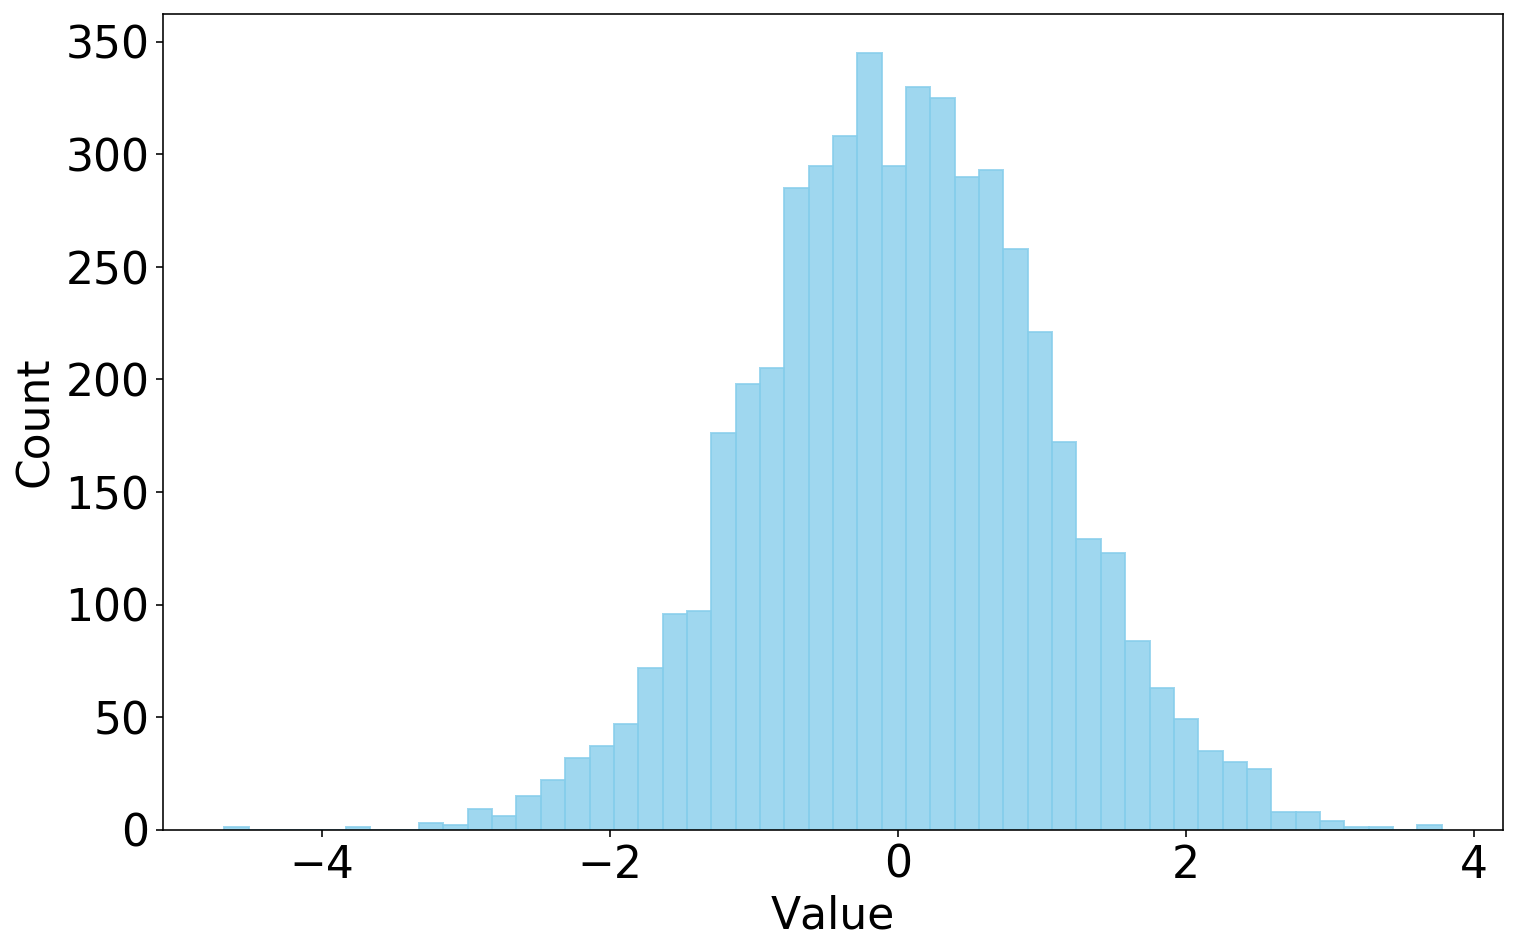

In [5]:
plt.figure()
plt.hist(z, bins=round(sample_size / 100), color='skyblue',
         alpha=0.8, edgecolor='skyblue')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()


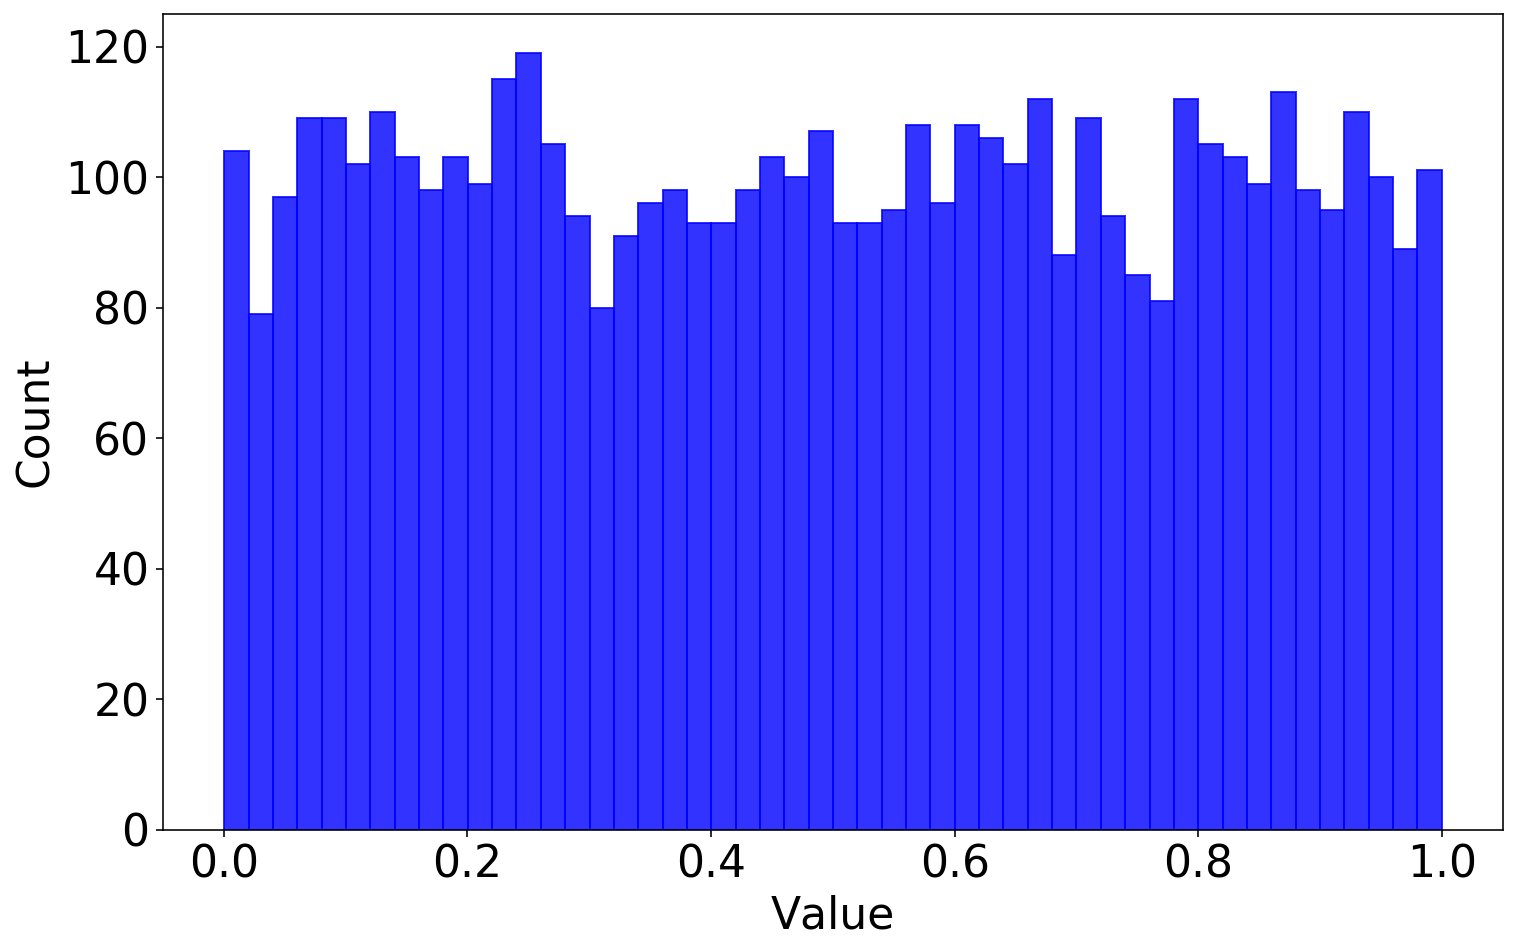

In [6]:
plt.figure()
plt.hist(u, bins=round(sample_size / 100), color='b',
         alpha=0.8, edgecolor='b')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()


 Both histograms look like their respective distributions. Now we can move on
 to implementing rejection sampling.

 ### Examining the target and enveloping distributions

 This example makes claims about plots, but shows none, so we'll first plot
 the target and envelope functions.

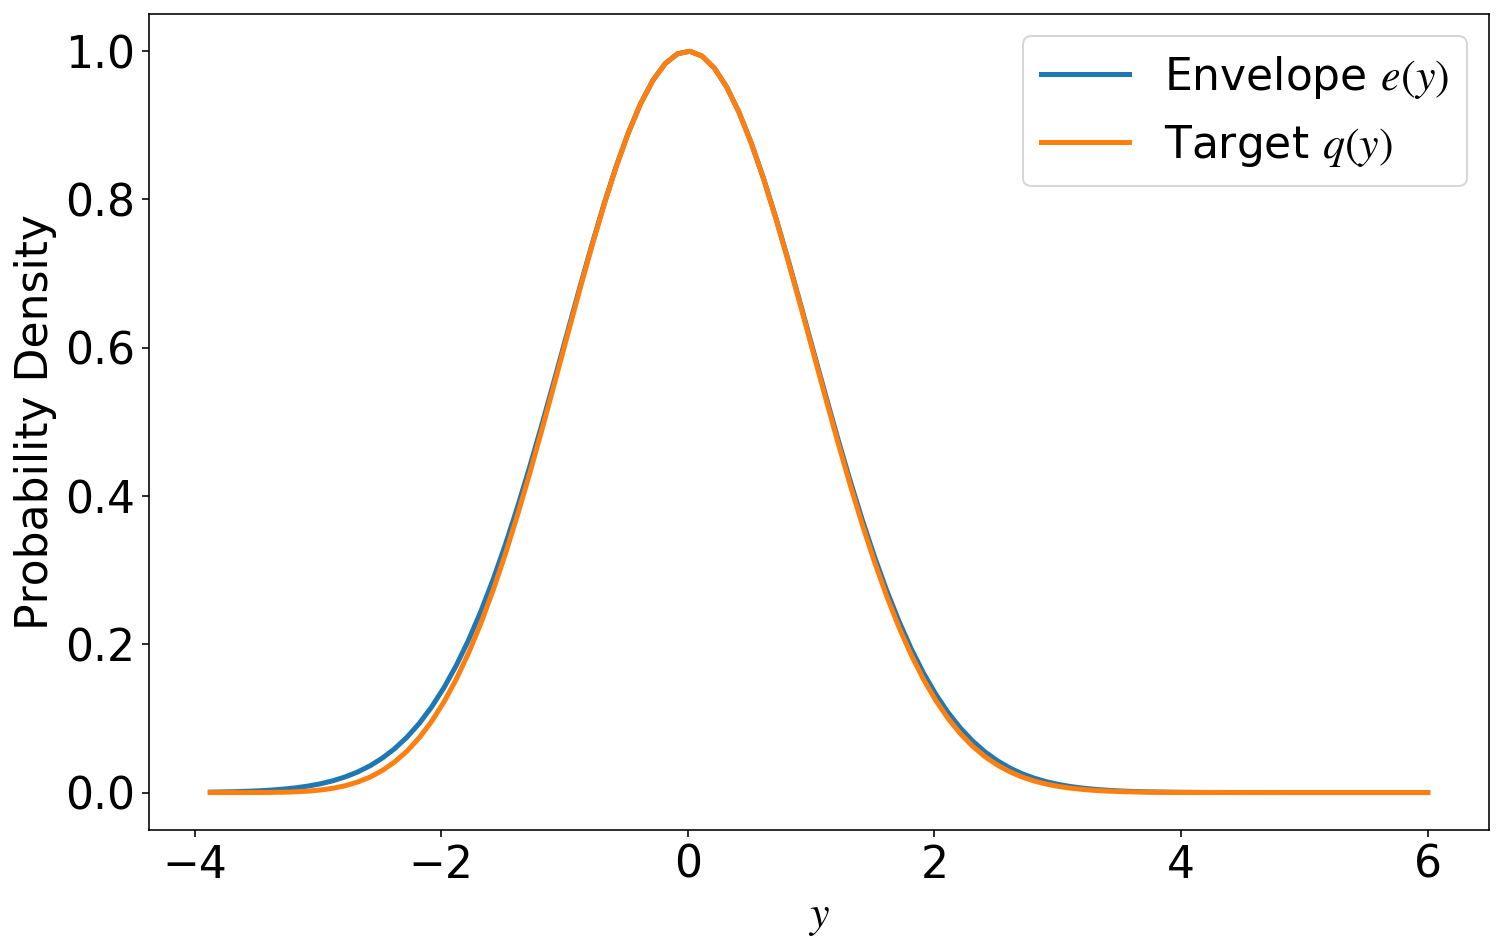

In [7]:
def calc_a(r):
    return r - 1 / 3


def calc_b(a):
    return 1 / np.sqrt(9 * a)


def calc_t(y, r):
    a = calc_a(r)
    b = calc_b(a)
    ty = a * (1 + b * y) ** 3
    return ty


def calc_q(y, r):
    a = calc_a(r)
    ty = calc_t(y, r)
    q = np.exp(a * np.log(ty / a) - ty + a)
    return q


def calc_e(y):
    e = np.exp(-y ** 2 / 2)
    return e


# Test the samples
r = 2
lft_lim = -1 / calc_b(calc_a(r))
rit_lim = 6
y = np.linspace(lft_lim, rit_lim, 100)
e = calc_e(y)
r = 2
q = calc_q(y, r)
plt.figure()
plt.plot(y, e, linewidth=2.5, label=r'Envelope $e(y)$')
plt.plot(y, q, linewidth=2.5, label=r'Target $q(y)$')
plt.legend()
plt.xlabel(r'$y$')
plt.ylabel(r'Probability Density')
plt.show()


 Those are indeed some very small numbers, and this looks like an excellent
 envelope.

 ### Implementation of rejection drawing for Example 6.1


In [8]:
def calc_discriminant(Z, r):
    a = calc_a(r)
    b = calc_b(a)
    tz = calc_t(Z, r)
    return np.exp(Z ** 2 / 2 + a * np.log(tz / a) - tz + a)


def draw_sample(r, sample_size):
    u = unif_rv.rvs(size=sample_size)
    z = norm_rv.rvs(size=sample_size)
    n_drawn = z.size
    tz = calc_t(z, r)
    is_pos = (tz >= 0)
    u = u[is_pos]
    z = z[is_pos]
    discriminant = calc_discriminant(z, r)
    z_keep = z[u <= discriminant]
    x = calc_t(z_keep, r)
    return x


def samples_needed(desired, accept_rate):
    return int(np.ceil(desired / accept_rate))


def rejection_draw(r, sample_size):
    x = draw_sample(r, sample_size=sample_size)
    n_drawn = sample_size
    accept_rate = x.size / n_drawn

    while x.size < sample_size:
        n_remain = sample_size - x.size
        new_sample_size = samples_needed(n_remain, accept_rate)
        x = np.hstack((x, draw_sample(r, sample_size=new_sample_size)))
        n_drawn = n_drawn + new_sample_size
        accept_rate = x.size / n_drawn

    x = x[:sample_size]

    return x, accept_rate


In [9]:
# Make the random draws
drawn_samples, accept_rate = rejection_draw(r, sample_size=sample_size)
print(f'With r = {r}, the acceptance rate for this envelope is'
      + f' {accept_rate * 100:.2f}%.')


With r = 2, the acceptance rate for this envelope is 98.23%.


 That acceptance rate is comparable to the results stated in _Computational
 Statistics_, falling between the quoted 95% for $r=1$ and 99% for $r=5$.
 Next for the plots.

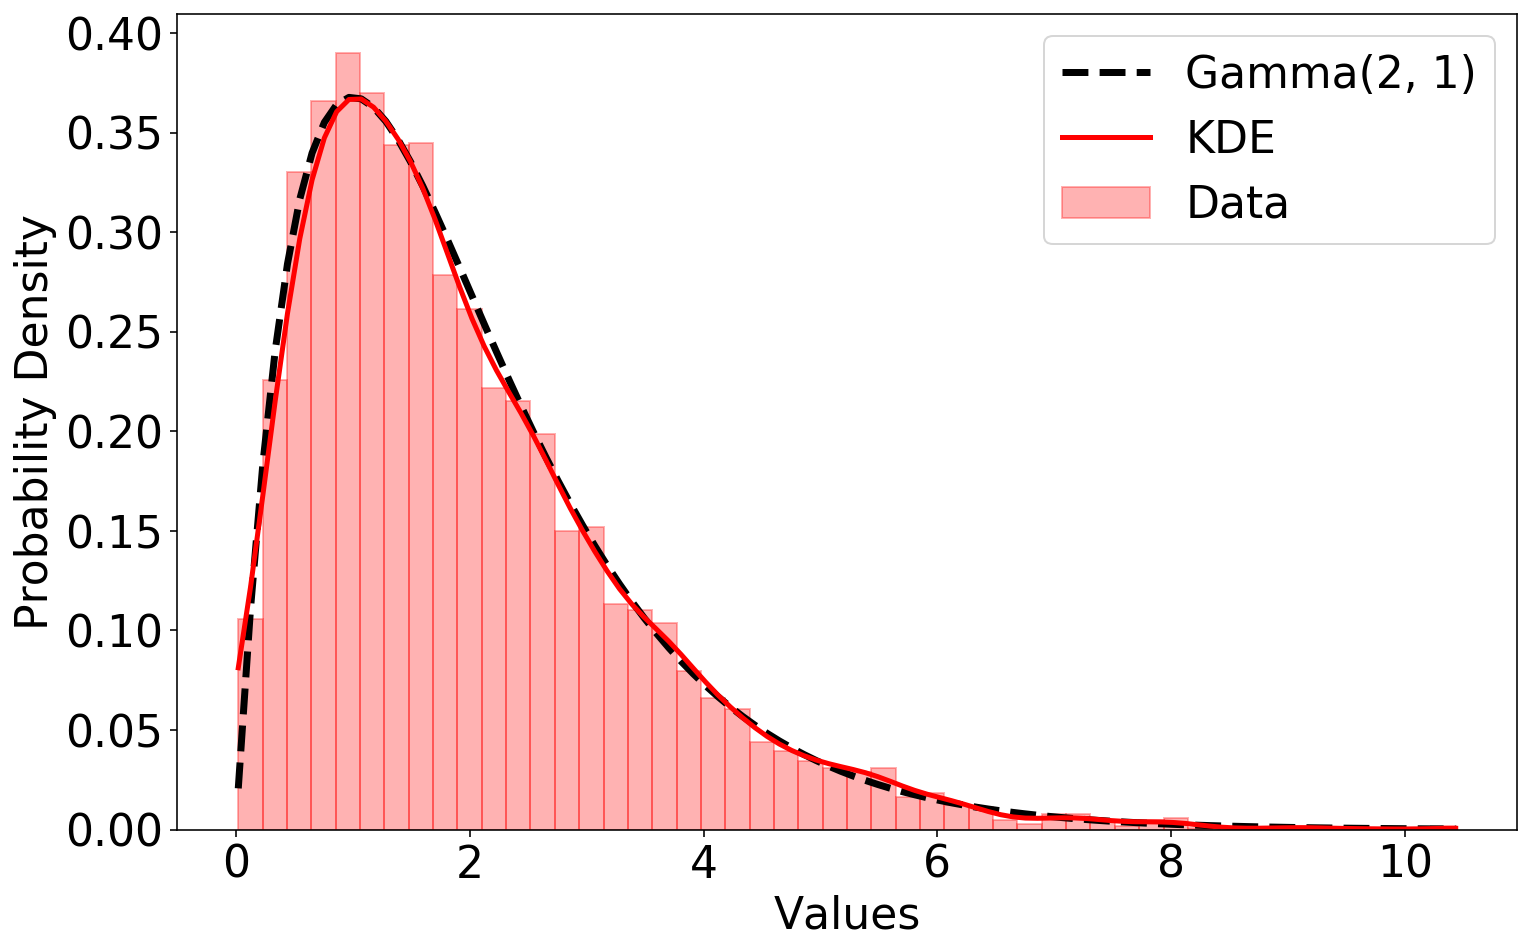

In [10]:
# Make the plot
plt.figure()
n_bins = round(sample_size / 100)
plt.hist(drawn_samples, bins=n_bins, density=True, label='Data', alpha=0.3,
         color='r', edgecolor='r')

# Plot the true probability density
n_points = 100
dom = np.linspace(drawn_samples.min(), drawn_samples.max(), n_points)
lambda_ = 1
true_density = stats.gamma.pdf(dom, a=r, loc=0, scale=1 / lambda_)
plt.plot(dom, true_density, 'k--', linewidth=3.5, label='Gamma(2, 1)')

# Plot the fitted density
sample_series = pd.Series(drawn_samples)
sample_series.plot.kde(ind=dom, color='r', label='KDE', linewidth=2.5)
plt.xlabel('Values')
plt.ylabel(r'Probability Density')
plt.legend()
plt.show()


 The kernel density estimate is nearly identical to the target distribution,
 with only the peak values near the maximum density deviating.


 <br>
 <br>

 ## Problem 2: Nonparametric random sample generation

 ---

 Generate a random sample with sample size $n = 5000$ according to the
 following probability density function (PDF)

 $$
 f(x) \propto \frac{1}{12} (1 + x) \exp\left\{- \frac{(x - 1)^2}{2x}\right\},\ x > 0.
 $$

 Produce a plot similar to FIGURE 6.2. Report the acceptance rate of your
 algorithm.

 > ___Note___: Your algorithm's acceptance rate must be higher than 50%

 Show the generated random samples by superimposing the following three items
 in another plot, using different line types for different curves, with a
 legend displayed.

 ### (a) Relative frequency histogram

 Include an appropriate number of bars for your generated random numbers with
 sample size $n = 5000$.

 ### (b) Estimated probability density curve

 Base the curve on your generated random numbers.

 ### (c) The true probability density curve.


 ### Plotting the density curve

 It will be easier to choose an envelope if we know shat the target density
 function looks like.

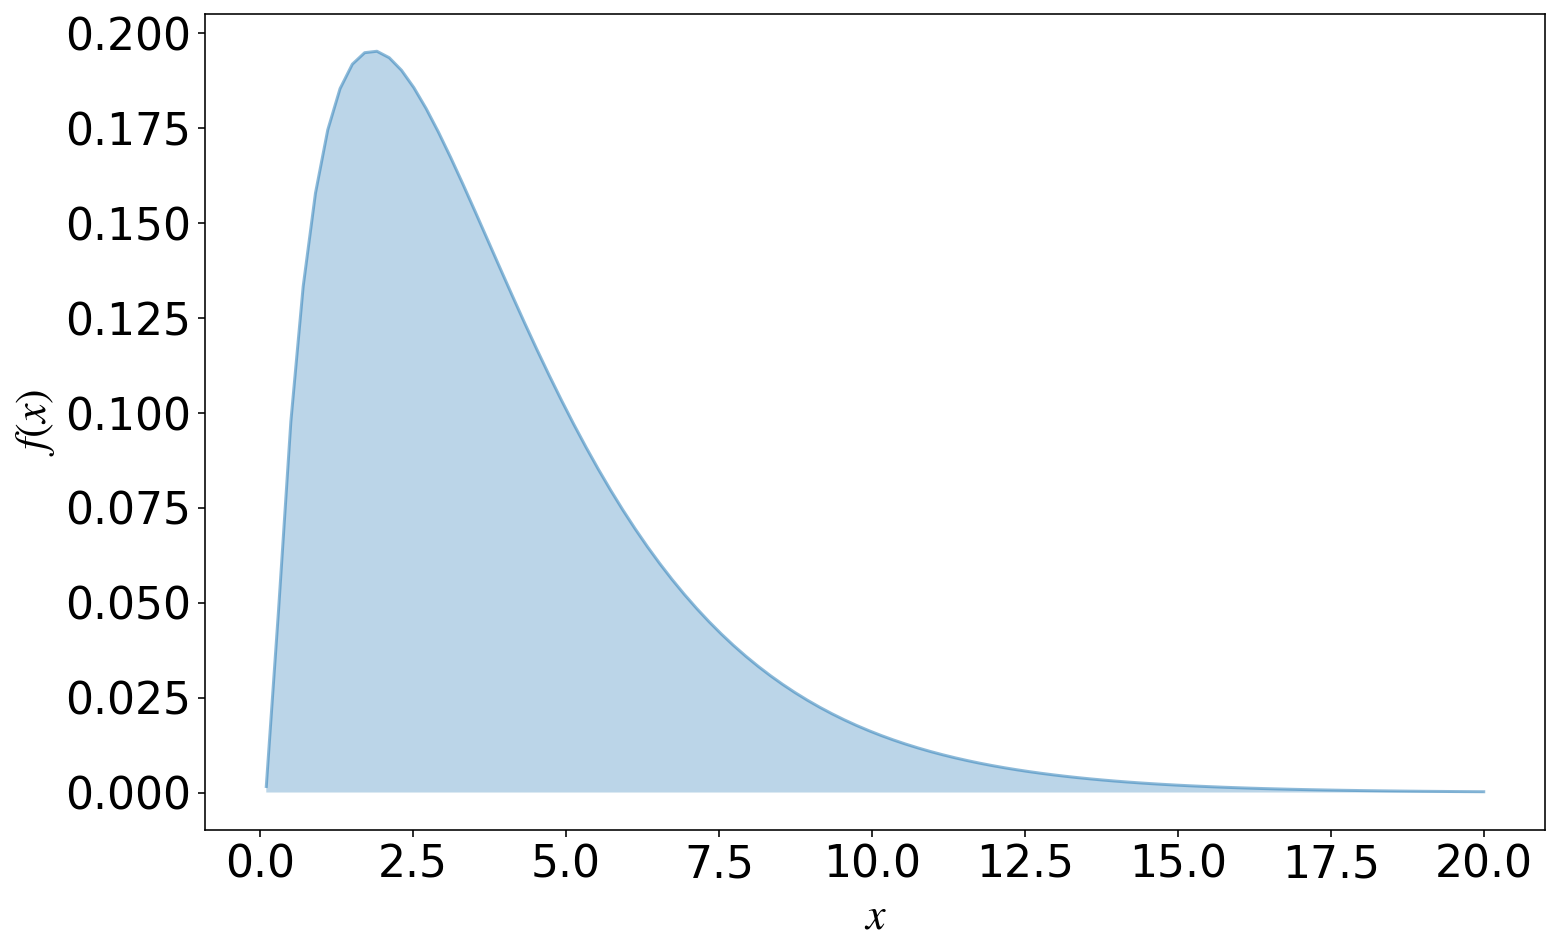

In [11]:


def target_pdf(x):
    x = x[x > 0]
    exponent = - (x - 1) ** 2 / 2 / x
    pdf = 1 / 12 * (1 + x) * np.exp(exponent)
    return pdf


dom = np.linspace(0.1, 20, n_points)
pdf = target_pdf(dom)

plt.figure()
plt.fill_between(dom, pdf, alpha=0.3)
plt.plot(dom, pdf, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel('$f(x)$')
plt.show()


 This looks similar to our plots of the Gamma distribution from above. Let's
 see if a set of parameters would be a good choice for an envelope function.

 ### Selecting an appropriate envelope

 Iterating through different parameter choices using subplots would be a good
 way to gauge the potential envelope quality.

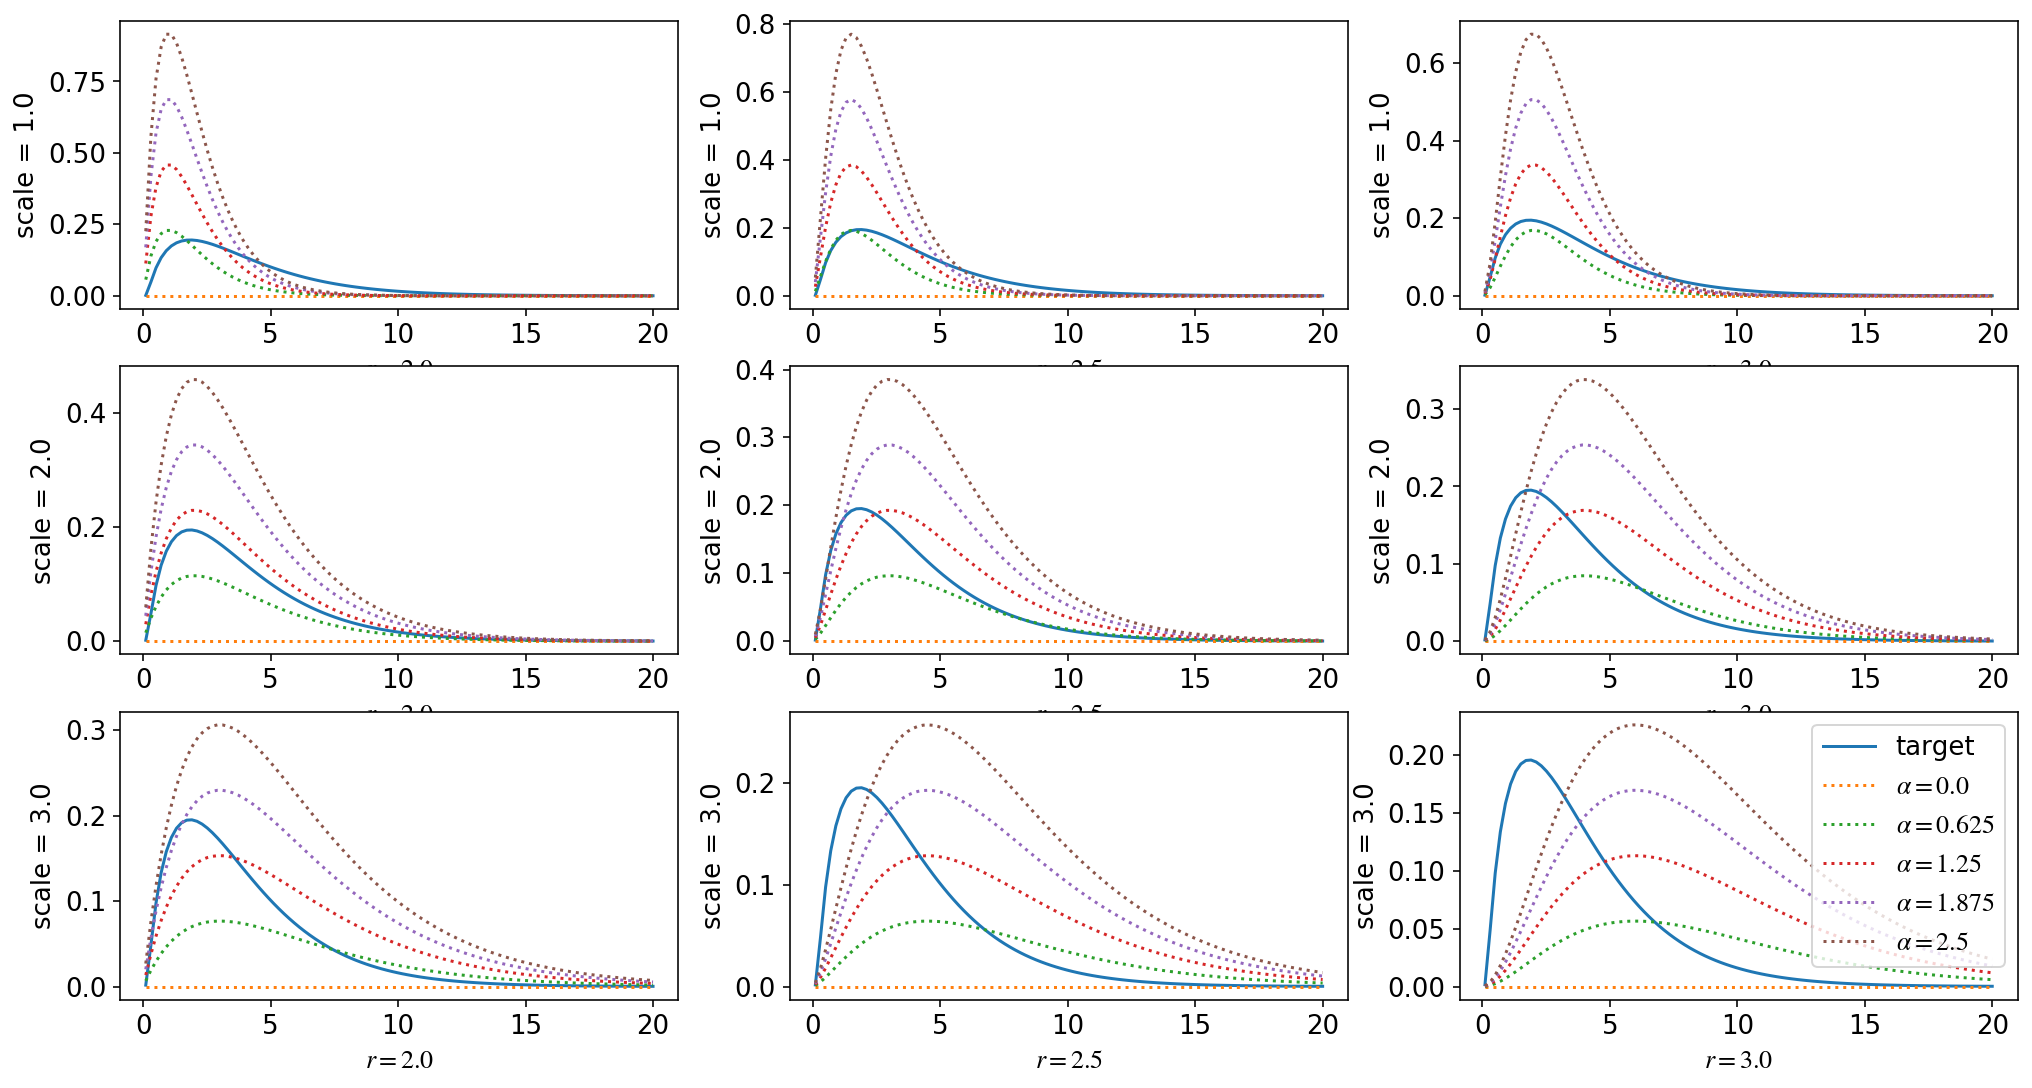

In [12]:
plt.rcParams['figure.figsize'] = (17, 9)
mpl.rcParams['font.size'] = 13
scale_start = 1
scale_stop = 3
n_scale_points = 3

r_start = 2
r_stop = 3
n_r_points = 3

n_beta_points = 5

plt.figure()
idx = 1
for scale in np.linspace(scale_start, scale_stop, n_scale_points):

    for a in np.linspace(r_start, r_stop, n_r_points):
        ax = plt.subplot(n_scale_points, n_r_points, idx)
        ax.plot(dom, pdf, label='target')
        idx += 1

        for beta in np.linspace(0, 2.5, n_beta_points):
            easy_pdf = stats.gamma.pdf(dom, a=a, loc=0, scale=scale)
            lbl = f'$\\alpha = {beta}$'
            ax.plot(dom, beta * easy_pdf, label=lbl, linestyle=':')

        ax.set_ylabel(f'scale = {scale}')
        ax.set_xlabel(f'$r = {a}$')

plt.legend()
plt.show()
plt.rcParams['figure.figsize'] = (12, 7.5)
mpl.rcParams['font.size'] = 22


 It looks like a value of $r = 2$, $\theta = 2$ ($\lambda = 1/2$), and $\alpha
 = 1.25$ are good starting points. Let's blow that plot up larger and tweak
 the values a bit.

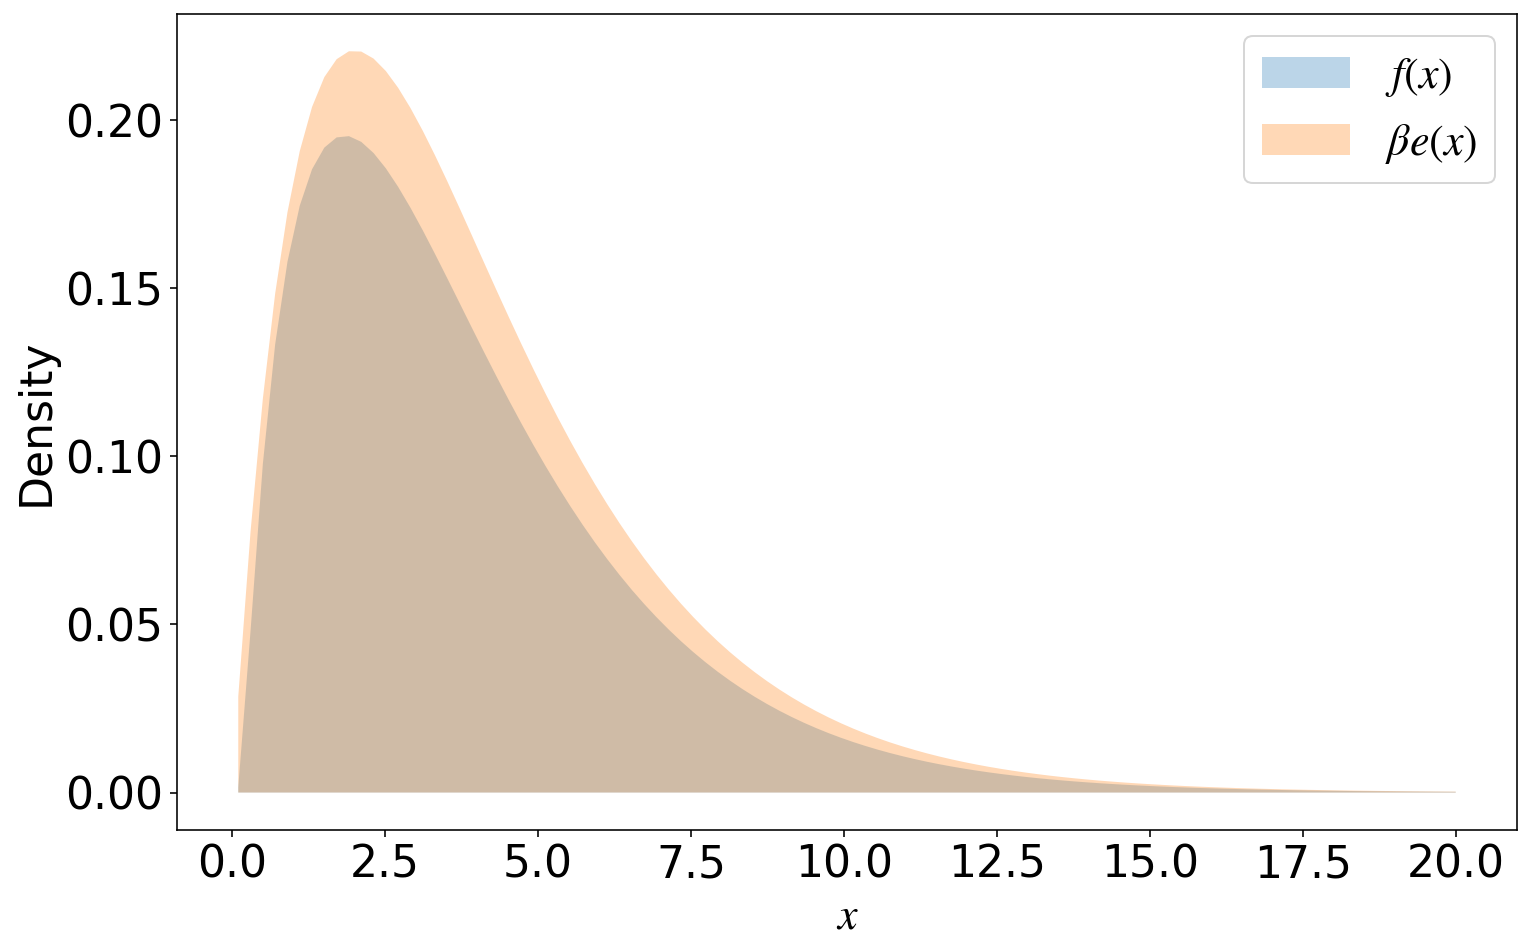

In [13]:
plt.figure()
plt.fill_between(dom, pdf, alpha=0.3, label=r'$f(x)$')
beta = 1.20
envelope = beta * stats.gamma.pdf(dom, a=2, loc=0, scale=2)
plt.fill_between(dom, envelope, alpha=0.3, label=r'$\beta e(x)$')
plt.xlabel(r'$x$')
plt.ylabel(r'Density')
plt.legend()
plt.show()


 That envelope looks efficient, so we can run through the rejection sampling
 algorithm, again.

 ### Implementing rejection sampling for the non-parametric density function

In [14]:


def draw_sample(sample_size):
    u = unif_rv.rvs(size=sample_size)
    y = stats.gamma(a=2, loc=0, scale=2).rvs(size=sample_size)
    n_drawn = y.size
    q = target_pdf(y)
    beta = 1.2
    envelope = beta * stats.gamma(a=2, loc=0, scale=2).pdf(y)
    is_good = (u <= (q / envelope))
    x = y[is_good]
    return x


def rejection_draw(sample_size):
    x = draw_sample(sample_size)
    n_drawn = sample_size
    accept_rate = x.size / n_drawn

    while x.size < sample_size:
        n_remain = sample_size - x.size
        new_sample_size = samples_needed(n_remain, accept_rate)
        x = np.hstack((x, draw_sample(new_sample_size)))
        n_drawn = n_drawn + new_sample_size
        accept_rate = x.size / n_drawn

    x = x[1:sample_size]
    return x, accept_rate


sample_size = 5000
drawn_samples, accept_rate = rejection_draw(sample_size=sample_size)
print(f'The acceptance rate for this envelope is {accept_rate * 100:.2f}%.')


The acceptance rate for this envelope is 84.62%.


 This acceptance rate is above 80%, which means our discard pile has about 25%
 of our sample size in it. For a sample size of 5000, that is 1250 extra
 draws. Now we can make the plot.

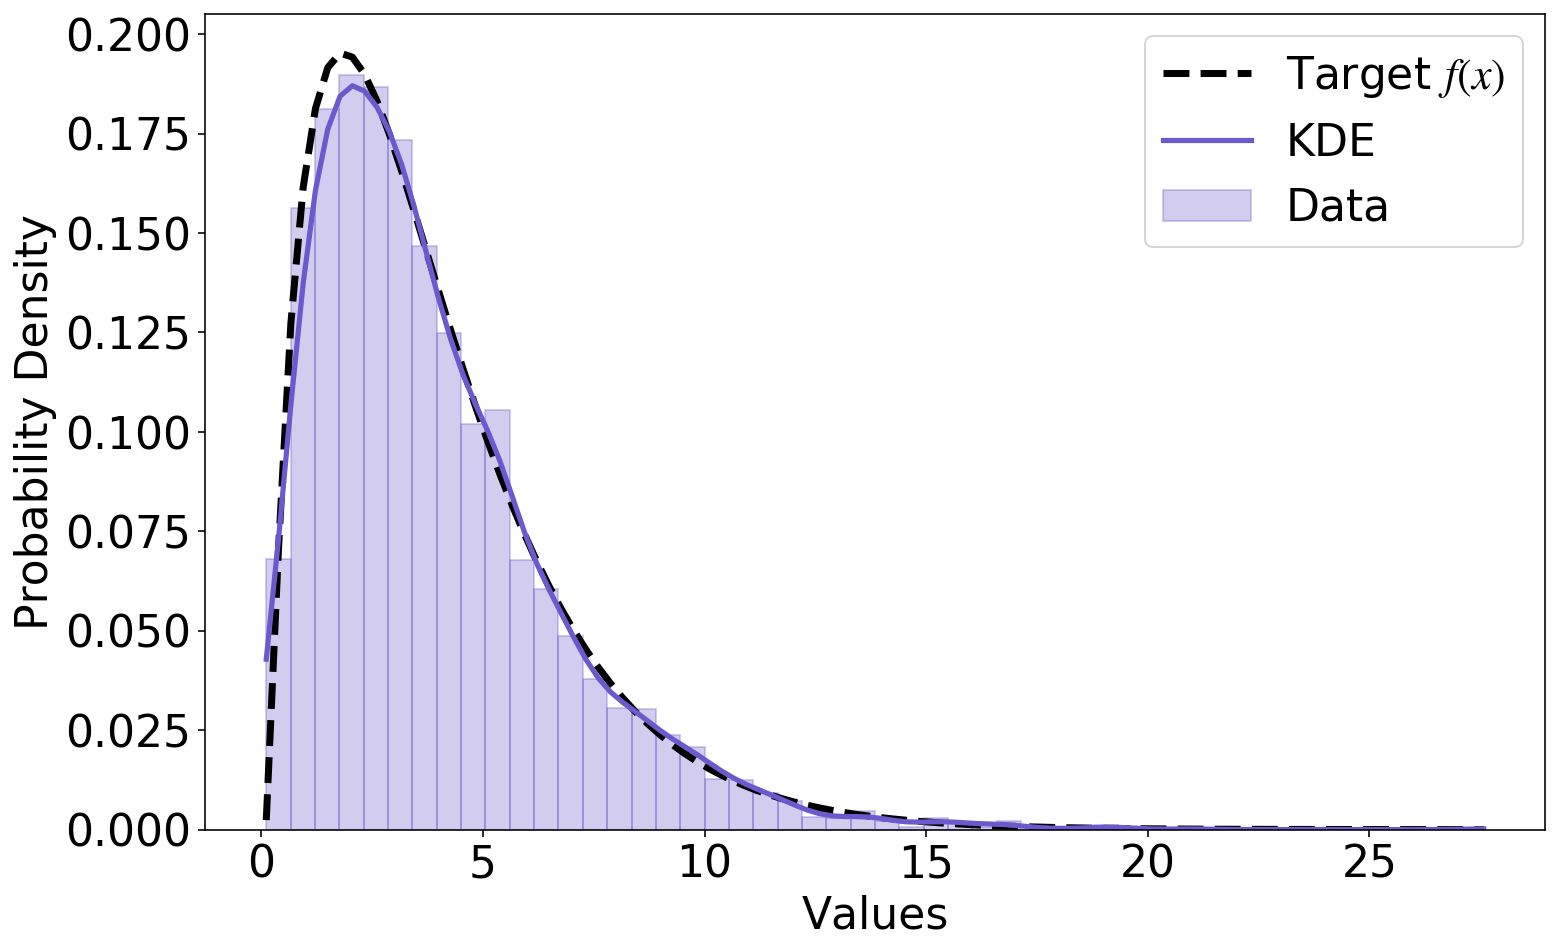

In [15]:
# Make the plot
plt.figure()
n_bins = round(sample_size / 100)
plt.hist(drawn_samples, bins=n_bins, density=True, label='Data', alpha=0.3,
         color='Slateblue', edgecolor='Slateblue')

# Plot the true probability density
n_points = 100
dom = np.linspace(drawn_samples.min(), drawn_samples.max(), n_points)
pdf = target_pdf(dom)
plt.plot(dom, pdf, 'k--', linewidth=3.5, label=r'Target $f(x)$')

# Plot the fitted density
pd.Series(drawn_samples).plot.kde(ind=dom, label='KDE', color='SlateBlue',
                                  linewidth=2.6)

plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.legend()
plt.show()



 <br>
 <br>

 ## Problem 3: Convergence in probability

 ---

 Let $U_1, U_2, \dots, U_n$ be a random sample from the UNIF\[0, 1\]
 distribution. Let

 $$
 U_{(n)} = \max\{ U_1, U_2, \dots, U_n \}
 $$

 Prove that $U_{(n)}$ converges to 1 in probability.


<br>
<br>

$$
U_1, U_2, \dots, U_n \stackrel{iid}{\sim} \mathrm{Unif}[0, 1]
$$

To save on typing, let

$$
Y = \max\left\{U_1, U_2, \dots, U_n\right\}
$$

Then the CDF of Y is found to be

$$
\begin{align}
P(Y < y) &= P(U_1 < y, U_2 < y, \dots, U_n < y) \\
            &= \prod_{i = 1}^n P(U_i < y) \\
            &= \prod_{i = 1}^n \left( \int_0^y f(u) \ \mathrm{d}u \right) \\
            &= \prod_{i = 1}^n \left( \int_0^y 1 \ \mathrm{d}u \right) \\
            &= \prod_{i = 1}^n y \\
\therefore P(Y < y) &= y^n. \\
\end{align}
$$

<br>
<br>

Convergence in probability is defined as
$$
\lim_{n \rightarrow \infty} P\big( \ |X_n - X| < \varepsilon \big) = 1.
$$

Ignoring the limit operator, temporarily, we have

$$
\begin{align}
P\big( \ | Y - 1 | < \varepsilon \ \big) &= P \big[ (Y - 1 < \varepsilon) \cup (1 - Y < \varepsilon) \big] \\
                        &= P\big( 1 - \varepsilon < Y < 1 + \varepsilon \big) \\
                        &= P\big( 1 - \varepsilon < Y < 1 \big) \\
                        &= P\big( Y < 1 \big) - P\big( Y < 1 - \varepsilon \big).\\
\end{align}
$$

Where it is noted that the CDF of $Y$ is a monotonically increasing function which becomes a constant value of unity for all $\{c \in \mathbb{R}: c \geq 1\}$, which allows the dropping of $\varepsilon$ in the upper CDF inequality.

Bringing the limit operator back in, we have

$$
\begin{align}
\lim_{n \rightarrow \infty} P\big( \ | Y - 1 | < \varepsilon \ \big) &= \lim_{n \rightarrow \infty} 1^n - \lim_{n \rightarrow \infty} (1 - \varepsilon)^n \\
    &= 1 - 0  \quad \forall \varepsilon \in (0, 1] \\
\therefore \lim_{n \rightarrow \infty} P\big( \ | Y - 1 | < \varepsilon \ \big) &= 1
\end{align}
$$

Since $Y = U_{(n)}$, this proves that $U_{(n)}$ converges to 1 in probability.